In [1]:
import numpy as np
#models
from sklearn import ensemble
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
import xgboost as xgb

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics
import seaborn as sns
import pickle
from scipy.stats import boxcox
from mpl_toolkits.mplot3d import Axes3D



In [2]:
# #############################################################################
# Real benchmarked dataset
#data = pd.read_csv('../../RealData/RealData_nginx_small.csv')
data = pd.read_csv('../../RealData/RealData_haproxy_big.csv')

## Log Syn. Data
#data = pd.read_csv('../../SynData/data/GeneratedLogData.csv')




   Unnamed: 0  CPU  throughput
0           0  0.1    49192.75
1           1  0.1    50082.85
2           2  0.1    49936.27
3           3  0.1    49879.74
4           4  0.1    47800.17
       Unnamed: 0         CPU     throughput
count    800.0000  800.000000     800.000000
mean     399.5000    0.550000  391121.643500
std      231.0844    0.287408  223930.035609
min        0.0000    0.100000   47112.290000
25%      199.7500    0.300000  202593.722500
50%      399.5000    0.550000  367637.085000
75%      599.2500    0.800000  581665.452500
max      799.0000    1.000000  786490.510000


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


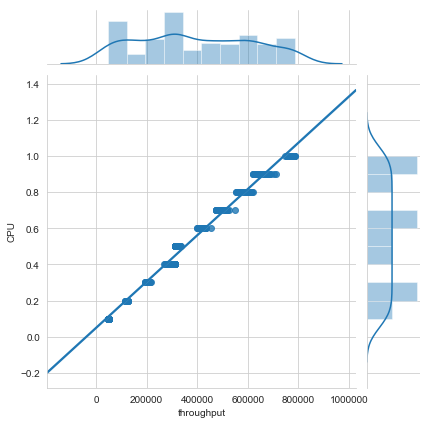

In [3]:
print(data.head())
print(data.describe())
sns.set_style('whitegrid')
sns.jointplot(x=data['throughput'],y=data['CPU'],kind="reg")

In [4]:
# #############################################################################
# Training and Testing Data
X = data[['throughput']]
y = data['CPU']
X = X.fillna(X.mean())

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=101)

# Cross Validation Split
n = len(X)
kf = KFold(n_splits=5, shuffle=True)
fold = 0
for train_index, test_index in kf.split(X):
    fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [5]:
# ################################MODELS#####################################

### GBM
params = {'n_estimators': [50, 100, 200], 'max_depth':[2, 4, 6], 'min_samples_split': [2, 4, 12],
          'learning_rate': [0.1, 0.01, 0.001], 'loss': ['ls', 'lad', 'huber', 'quantile']}
gb = ensemble.GradientBoostingRegressor()
gbm = GridSearchCV(gb, params, verbose=1, n_jobs=-1)
gbm.fit(X_train, y_train)

predictionGBM  = gbm.predict(X_test)
predictionGBM = np.array(predictionGBM)

#### LASSO
lasso = Lasso(alpha=0.1)
lasso = GridSearchCV(lasso, {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}, verbose=1, n_jobs=-1)
lasso.fit(X_train, y_train)

predictionLasso  = lasso.predict(X_test)
predictionLasso = np.array(predictionLasso)

### XGB
xgb = xgb.XGBRegressor()
xgb.fit(X_train, y_train)

predictionXgb  = xgb.predict(X_test)
predictionXgb = np.array(predictionXgb)

### Linear
lm = LinearRegression()
lm.fit(X_train,y_train)

predictionLinear  = lm.predict(X_test)
predictionLinear = np.array(predictionLinear)

### Ridge
rm = Ridge()
rm.fit(X_train,y_train)
ridge = GridSearchCV(rm, {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}, verbose=1, n_jobs=-1)
ridge.fit(X_train, y_train)

predictionRm  = ridge.predict(X_test)
predictionRm = np.array(predictionRm)

### Random Forest
rf = RandomForestRegressor(n_estimators=2, min_weight_fraction_leaf=0.02)
rf.fit(X_train,y_train)

predictionRf  = rf.predict(X_test)
predictionRf = np.array(predictionRf)

### SVM
clf = SVR(kernel='rbf')
svr = GridSearchCV(clf, {'C': [1000, 20000], 'coef0': [0, 1]}, verbose=1, n_jobs=-1, cv=10)
svr.fit(X_train, y_train)

predictionSvm  = svr.predict(X_test)
predictionSvm = np.array(predictionSvm)


Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 715 tasks      | elapsed:   11.2s


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:   15.4s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. T

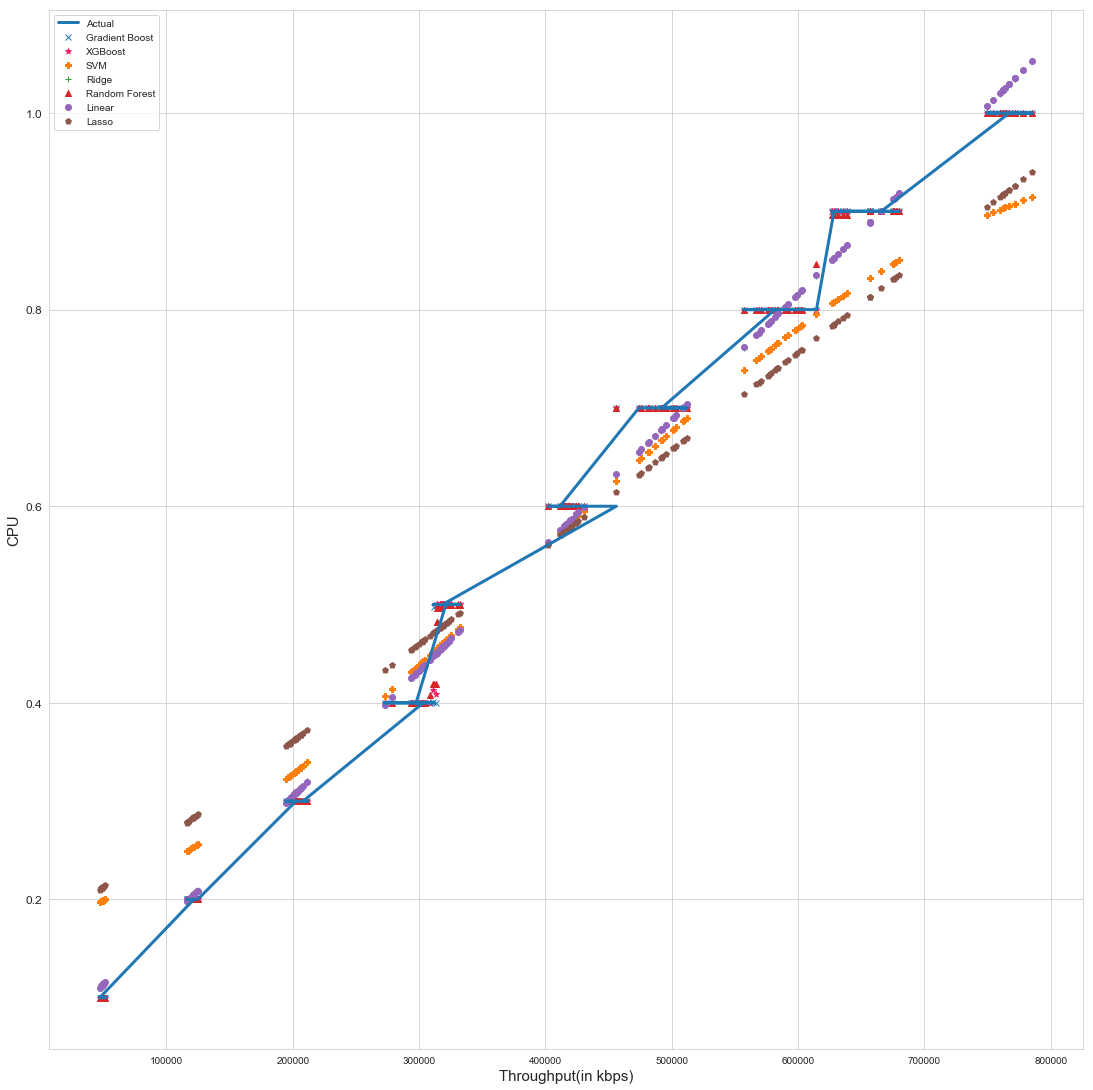

In [6]:
#Plot prediction
X_test = scaler.inverse_transform(X_test)
fig = plt.figure(figsize=(15, 15))

plt.plot(X_test, y_test,  linewidth=3,label="Actual")
plt.scatter(X_test, predictionGBM, linewidth=1,label="Gradient Boost", marker='x')
plt.scatter(X_test, predictionXgb, linewidth=1,label="XGBoost",color='#fe1c64', marker='*')
plt.scatter(X_test, predictionSvm, linewidth=1,label="SVM", marker='P')
plt.scatter(X_test, predictionRm, linewidth=1,label="Ridge", marker='+')
plt.scatter(X_test, predictionRf, linewidth=1,label="Random Forest", marker='^')
plt.scatter(X_test, predictionLinear, linewidth=1,label="Linear")
plt.scatter(X_test, predictionLasso, linewidth=1,label="Lasso", marker='p')
plt.tight_layout()


plt.xlabel("Throughput(in kbps)",size=15)
plt.ylabel("CPU",size=15)
plt.yticks(fontsize=12)
plt.legend()